In [7]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook


In [8]:
def tanh(x):
    return np.tanh(x)


def relu(x):
    return np.maximum(0, x)


In [9]:
class RecirculatedAutoEncoder:
    """Recirculated autoencoder.
    
    Parameters
    ----------
    n_neurons : array-like, shape (n_layers)
        Number of neurons per layer
        
    activation_functions : function or list of functions, optional.
        Activation function for each layer.
        
    learning_rate : array-like, optional
        If a single number, every layer uses the same learning rate.
        Otherwise, the incoming weights to layer n are updated with learning_rate[n].
        
    regression_coefficient : array-like, optional
        Regression coefficient, in range [0, 1].
        
    symmetric : boolean, optional
    
    """

    def __init__(self, n_neurons, activation_functions=relu, learning_rate=1, regression_coefficient=0.75, symmetric=False):
        if symmetric:
            n_neurons = n_neurons + n_neurons[-2:0:-1]

        self.n_neurons_ = np.array(n_neurons)
        self.n_layers_ = len(self.n_neurons_)

        if type(activation_functions) is not list:
            self.activation_functions_= [activation_functions] * (self.n_layers_)
        elif len(activation_functions) == 2 and symmetric:
            self.activation_functions_= [
                activation_functions[0]] * (self.n_layers_ // 2) + [activation_functions[1]] * (self.n_layers_ // 2)
        else:
            self.activation_functions_= activation_functions

        if len(self.activation_functions_) != self.n_layers_:
            raise ValueError(
                'An activation function is required for every layer.')

        if learning_rate * 0 == 0:
            self.learning_rate_ = np.array([learning_rate] * len(n_neurons))
        else:
            self.learning_rate_ = np.array(learning_rate)

        if regression_coefficient * 0 == 0:
            self.regression_coefficient_ = np.array([regression_coefficient] * len(n_neurons))
        else:
            self.regression_coefficient_ = np.array(regression_coefficient)

        # Initialize weight matrices to random weights in the interval [-0.5, 0.5]
        self.weights_ = []

        for i in range(self.n_layers_ - 1):
            self.weights_.append(np.random.random(
                (self.n_neurons_[i] + 1, self.n_neurons_[i+1])) - 0.5)

        self.weights_.append(np.random.random(
            (self.n_neurons_[-1] + 1, self.n_neurons_[0])) - 0.5)

    def recirculate(self, inputs, update=True):
        a = []
        for n in self.n_neurons_:
            a.append(np.ones((inputs.shape[0], 2, n + 1)))

        # 1st propagation
        a[0][:, 0, :-1] = inputs
        for i in range(self.n_layers_ - 1):
            a[i+1][:, 0, :-
                   1] = self.activation_functions_[i](a[i][:, 0, :] @ self.weights_[i])

        # 2nd propagation
        a[0][:, 1, :-1] = self.regression_coefficient_[0] * a[0][:, 0, :-1] + \
            (1 - self.regression_coefficient_[0]) * self.activation_functions_[-1](a[-1]
                                                     [:, 0, :] @ self.weights_[-1])
        for i in range(1, self.n_layers_):
            a[i][:, 1, :-1] = self.regression_coefficient_[i] * a[i][:, 0, :-1] + \
                (1 - self.regression_coefficient_[i]) * self.activation_functions_[i -
                                                     1](a[i-1][:, 1, :] @ self.weights_[i-1])

        # weight updates
        for i in range(len(self.weights_) - 1):
            self.weights_[i] += self.learning_rate_[i] * a[i][:, 1,
                                                   :].T @ (a[i+1][:, 0, :-1] - a[i+1][:, 1, :-1])
        self.weights_[-1] += self.learning_rate_[-1] * a[-1][:, 0,
                                                  :].T @ (a[0][:, 0, :-1] - a[0][:, 1, :-1])

        return 0.5 * ((inputs - a[0][:, 1, :-1]) ** 2).sum()

    def encode(self, inputs, layer):
        a = []
        for n in self.n_neurons_:
            a.append(np.ones((inputs.shape[0], n + 1)))

        # 1st propagation
        a[0][:, :-1] = inputs
        for i in range(self.n_layers_ - 1):
            a[i+1][:, :-1] = self.activation_functions_[i](a[i][:, :] @ self.weights_[i])

        # Return the desired layer and the reconstructed output
        return a[layer][:, :-1], self.activation_functions_[-1](a[-1][:, :] @ self.weights_[-1])


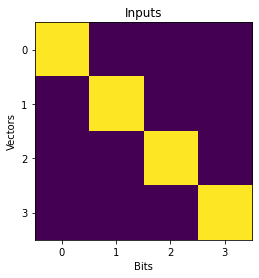

In [10]:
autoencoder = RecirculatedAutoEncoder(n_neurons=[4, 2], activation_functions=[
    tanh,relu], learning_rate=1, regression_coefficient=[0.75, 0])

inputs = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])

%matplotlib inline
fig = plt.figure()
ax = fig.subplots(1, 1)
ax.imshow(inputs)
ax.set_title('Inputs')
ax.set_ylabel('Vectors')
ax.set_xlabel('Bits')
ax.set_xticks([0, 1, 2, 3])
ax.set_yticks([0, 1, 2, 3])

error = np.empty(100)
for i in range(100):
    error[i] = autoencoder.recirculate(inputs)


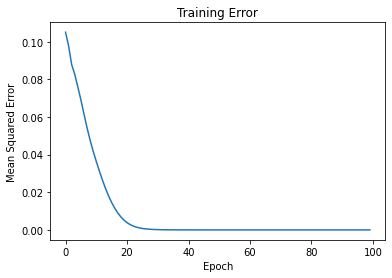

In [11]:
fig = plt.figure()
ax = fig.subplots(1, 1)
ax.plot(error)
ax.set_title('Training Error')
ax.set_ylabel('Mean Squared Error')
ax.set_xlabel('Epoch')
plt.show()


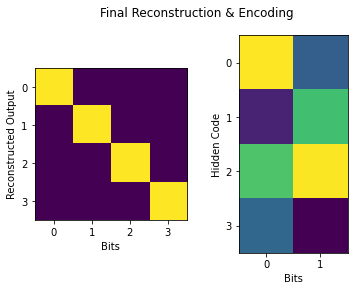

In [12]:
coded, recon = autoencoder.encode(inputs, layer=1)

fig2 = plt.figure()
fig2.suptitle('Final Reconstruction & Encoding')
axes = fig2.subplots(1, 2)
axes[0].imshow(recon)
axes[0].set_ylabel('Reconstructed Output')
axes[0].set_xlabel('Bits')
axes[0].set_xticks([0, 1, 2, 3])
axes[0].set_yticks([0, 1, 2, 3])
axes[1].imshow(coded)
axes[1].set_ylabel('Hidden Code')
axes[1].set_xlabel('Bits')
axes[1].set_yticks([0, 1, 2, 3])
axes[1].set_xticks([0, 1])
plt.show()
